## Imports

In [1]:
import gc
import numpy as np
import matplotlib.pyplot as plt
import torch
from warnings import filterwarnings
import pickle
import os

import torch_geometric
import torch
from torch_geometric.loader import DataLoader

from src.utils.commons import get_config, get_device, set_seed
from src.model.gae import GAE
from src.training.train_cf import train
from src.data.loader import GraphDataset
from src.utils.commons import get_config
from src.utils.plot import Plot

# Inputs

In [ ]:
config_path = 'configs/final/CF_NACA0012SAGE.yaml'
is_train = False

# Initialization

## Dataset

In [3]:
filterwarnings('ignore')
torch.cuda.empty_cache()
gc.collect()

config = get_config(config_path)
set_seed(config['config']['seed'])

train_dataset = GraphDataset(config = config['config'], split = 'train')
val_dataset = GraphDataset(config = config['config'], split = 'val')
device = get_device()
    
surface_mask = train_dataset.surface_mask

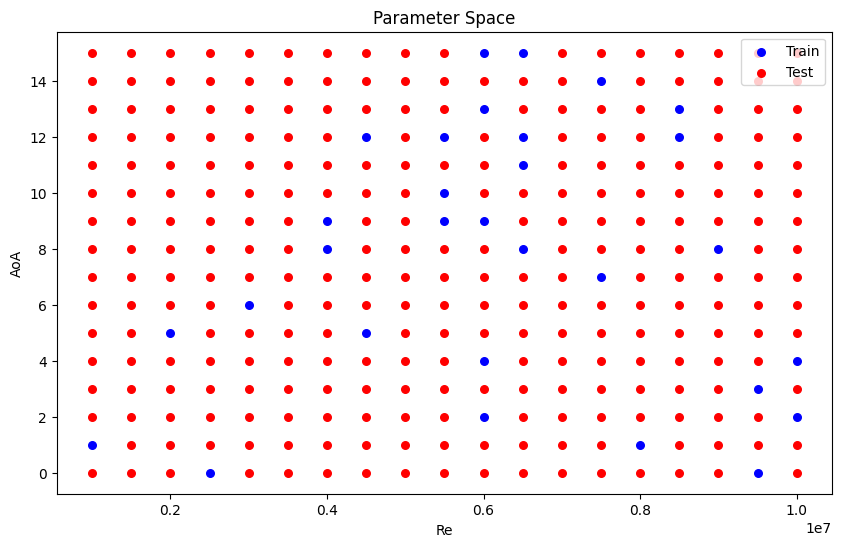

In [59]:
train_params_list = np.array([[int(keys.split('_')[1]), int(keys.split('_')[3])] for keys in train_dataset.file_keys]).reshape(-1, 2)
test_params_list = np.array([[int(keys.split('_')[1]), int(keys.split('_')[3])] for keys in val_dataset.file_keys]).reshape(-1, 2)

plt.figure(figsize=(10, 6))
# plt.grid(True)
plt.xlabel('Re')
plt.ylabel('AoA')
plt.title('Parameter Space')
plt.scatter(train_params_list[:, 0], train_params_list[:, 1], c='blue', s=30, label='Train')
plt.scatter(test_params_list[:, 0], test_params_list[:, 1], c='red', s=30, label='Test')
plt.legend()
plt.show()

## Model

In [5]:
model_name = config['training']['model_name']
num_epochs = config['training']['epochs']
model_path = f"artifacts/surface/{model_name}/{model_name}_best_model_{num_epochs}.pth"

linear_ae_input_size = train_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1]
model = GAE(config = config, ae_input_size = linear_ae_input_size).to(device)

if not is_train:
    from src.utils.commons import load_model
    model = load_model(model_path, config=config, ae_input_ize=train_dataset[0].x.shape[0] * config["model"]['encoder']['convolution_layers']['hidden_channels'][-1])

model = model.to(device)

# Training

In [6]:
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=1, 
                          shuffle=False,
                          num_workers=config['training']['num_workers'])

val_loader = DataLoader(dataset=val_dataset, 
                        batch_size=1, 
                        shuffle=False,
                        num_workers=config['training']['num_workers'])

if is_train:
    history = train(model = model, 
                    device = device, 
                    surface_mask = surface_mask,
                    lambda_surface=1,
                    train_loader = train_loader, 
                    is_val = True,
                    val_loader = val_loader, 
                    start_up_epoch=20,
                    save_best_model=True,
                    save_history=True,
                    config = config['training'])

    train_history, val_history = history
    from src.utils.commons import save_config
    save_config(config, task='surface')

### Training History

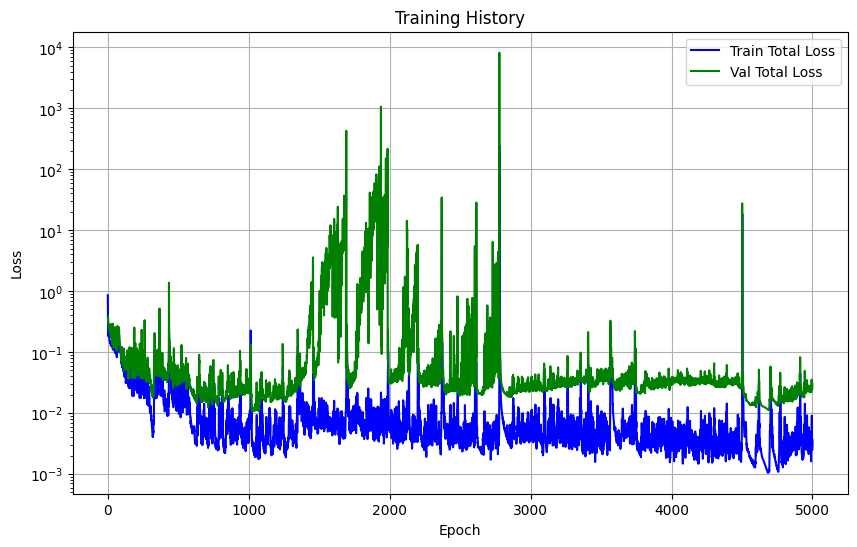

In [7]:
with open(f"artifacts/surface/{model_name}/{model_name}_history_{num_epochs}.pkl", 'rb') as f:
    # Load the history dictionary
    train_history = pickle.load(f)
    val_history = pickle.load(f)
    
train_total_loss = train_history['train_loss']
val_total_loss = val_history['val_loss']    

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_total_loss, label='Val Total Loss', color='green')
# plt.ylim(0.0001, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

### Plot train loss history

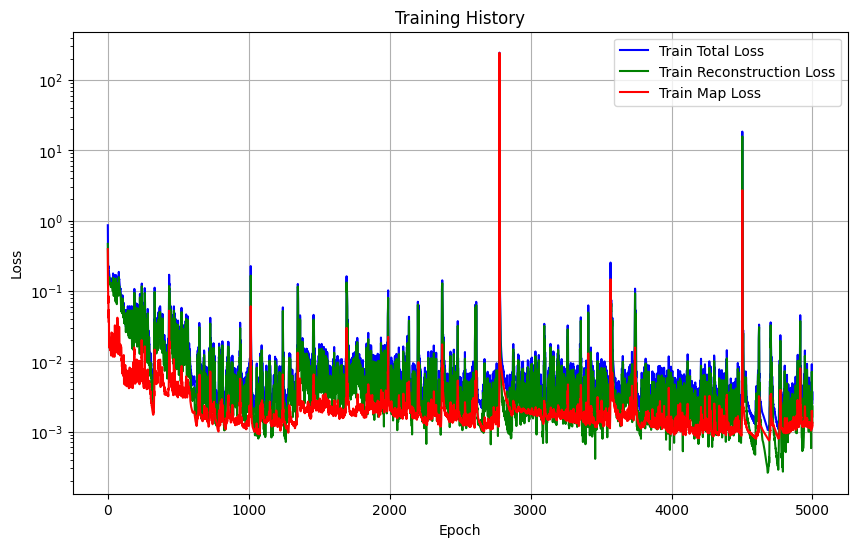

In [8]:
train_total_loss = train_history['train_loss']
train_reconstruction_loss = train_history['reconstruction_loss']
train_map_loss = train_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_total_loss, label='Train Total Loss', color='blue')
plt.plot(train_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(train_map_loss, label='Train Map Loss', color='red')
# plt.ylim(0.0001, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

### Plot validation loss history

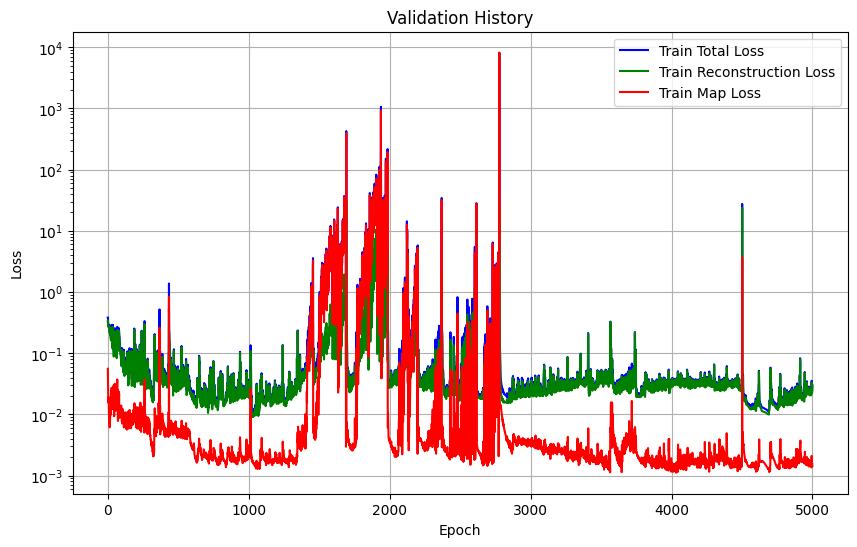

In [9]:
val_total_loss = val_history['val_loss']
val_reconstruction_loss = val_history['reconstruction_loss']
val_map_loss = val_history['map_loss']

plt.figure(figsize=(10, 6))
plt.plot(val_total_loss, label='Train Total Loss', color='blue')
plt.plot(val_reconstruction_loss, label='Train Reconstruction Loss', color='green')
plt.plot(val_map_loss, label='Train Map Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0.0001, 1)
# plt.ylim(0.001, 10)
plt.title('Validation History')
plt.legend()
plt.grid(True)
plt.yscale('log') 
plt.show()

## Plot results

### Matplotlib Plotting

In [10]:
with open(os.path.join(config['config']['split_dir'], 'scaler.pkl'), 'rb') as f:
    scaler = f.read()
    
plot = Plot(train_dataset=train_dataset, val_dataset=val_dataset, model=model)

Original

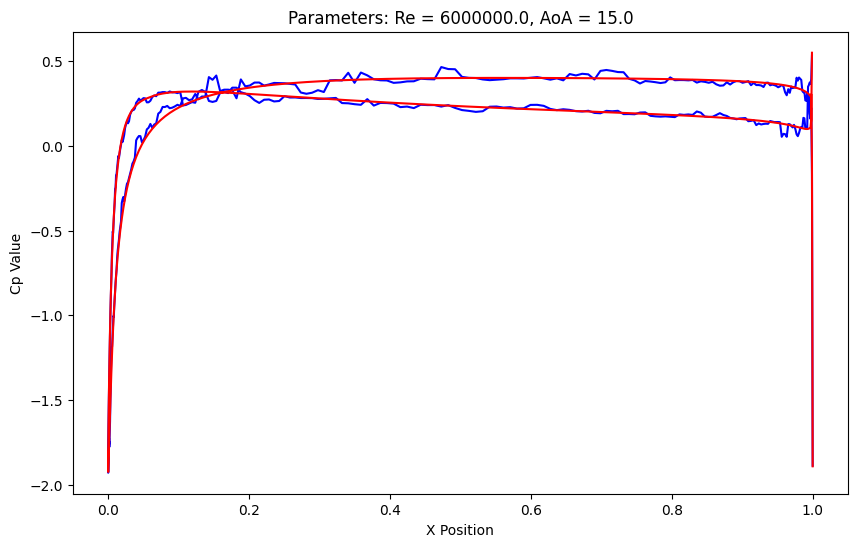

Cfx MSE: 0.0033097390551120043


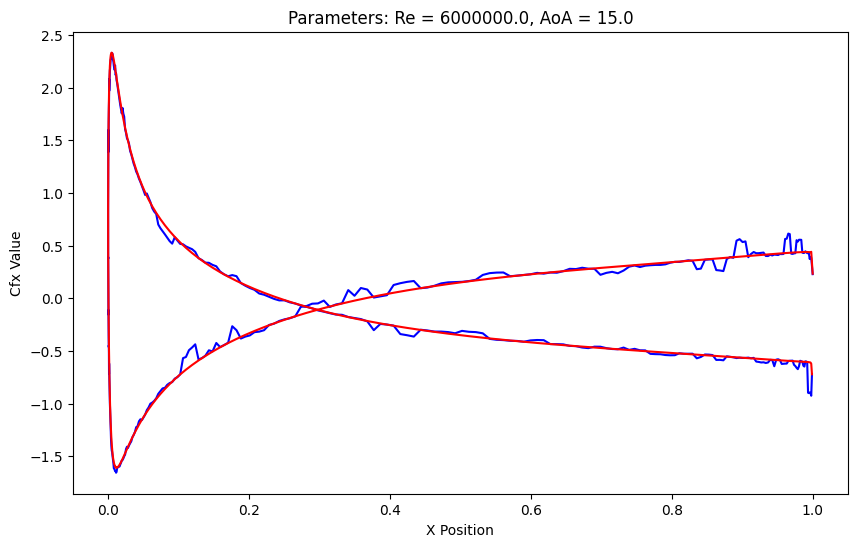

Cfy MSE: 0.004101798869669437


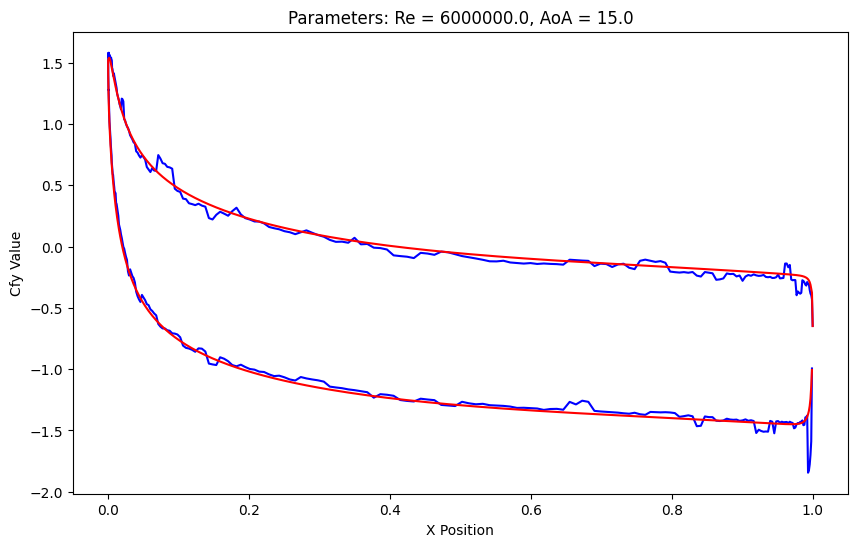

In [11]:
index = 14

test_plot_data = train_dataset[index].to(device)
test_param = test_plot_data.params

estimated_x, latent_variables, estimated_latent_variables = model(test_plot_data, test_param)
estimated_x = estimated_x.detach().cpu().numpy()

plt.figure(figsize=(10, 6))
plt.title(f"Parameters: Re = {test_param[0].item()}, AoA = {test_param[1].item()}")
plt.xlabel('X Position')
plt.ylabel('Cp Value')
plt.plot(test_plot_data.pos[:, 0].cpu().numpy(), estimated_x[:, 0], label='Estimated Cp', color='blue')
plt.plot(test_plot_data.pos[:, 0].cpu().numpy(), test_plot_data.y[:, 0].cpu().numpy(), label='Ground Truth Cp', color='red')
plt.show()

print(f"Cfx MSE: {torch.nn.functional.mse_loss(input=torch.tensor(estimated_x[:, 1]), target=torch.tensor(test_plot_data.y[:, 1].cpu().numpy()), reduction='mean')}")
plt.figure(figsize=(10, 6))
plt.title(f"Parameters: Re = {test_param[0].item()}, AoA = {test_param[1].item()}")
plt.xlabel('X Position')
plt.ylabel('Cfx Value')
plt.plot(test_plot_data.pos[:, 0].cpu().numpy(), estimated_x[:, 1], label='Estimated Cp', color='blue')
plt.plot(test_plot_data.pos[:, 0].cpu().numpy(), test_plot_data.y[:, 1].cpu().numpy(), label='Ground Truth Cp', color='red')
plt.show()

print(f"Cfy MSE: {torch.nn.functional.mse_loss(input=torch.tensor(estimated_x[:, 2]), target=torch.tensor(test_plot_data.y[:, 2].cpu().numpy()), reduction='mean')}")
plt.figure(figsize=(10, 6))
plt.title(f"Parameters: Re = {test_param[0].item()}, AoA = {test_param[1].item()}")
plt.xlabel('X Position')
plt.ylabel('Cfy Value')
plt.plot(test_plot_data.pos[:, 0].cpu().numpy(), estimated_x[:, 2], label='Estimated Cp', color='blue')
plt.plot(test_plot_data.pos[:, 0].cpu().numpy(), test_plot_data.y[:, 2].cpu().numpy(), label='Ground Truth Cp', color='red')
plt.show()

plt.close()

# Evaluation metric

In [12]:
from src.utils.metrics import mse_error, mae_error, rmse_error, relative_error
from src.training.test import test

error_func = [mse_error, mae_error, rmse_error, relative_error]
test_results, total_error = test(model = model, 
                                 test_loader = val_loader,
                                 device = device, 
                                 error_func = error_func)

total_error

{'total_mse_error': 0.2149412125306712,
 'total_mae_error': 0.27695648223839026,
 'total_rmse_error': 0.3547649978236719,
 'total_relative_error': 0.12304165803912011}